In [3]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 30.7 ms, sys: 4.56 ms, total: 35.2 ms
Wall time: 5.92 s


In [4]:
import ultralytics
print(ultralytics.__version__)

8.1.10


In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8x'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/drive/MyDrive/archive/css-data/'
    OUTPUT_DIR = './'


In [8]:
import os

In [9]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [10]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/drive/MyDrive/archive/css-data/test
train: /content/drive/MyDrive/archive/css-data/train
val: /content/drive/MyDrive/archive/css-data/valid



In [37]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



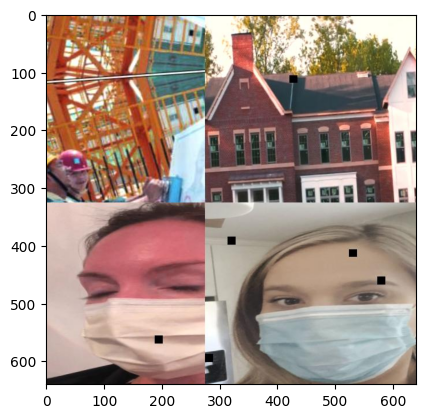

In [12]:
example_image_path = '/content/drive/MyDrive/archive/css-data/train/images/-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [13]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)


    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]


    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")


    selected_files = random.sample(image_files, num_images)


    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):

        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')

    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

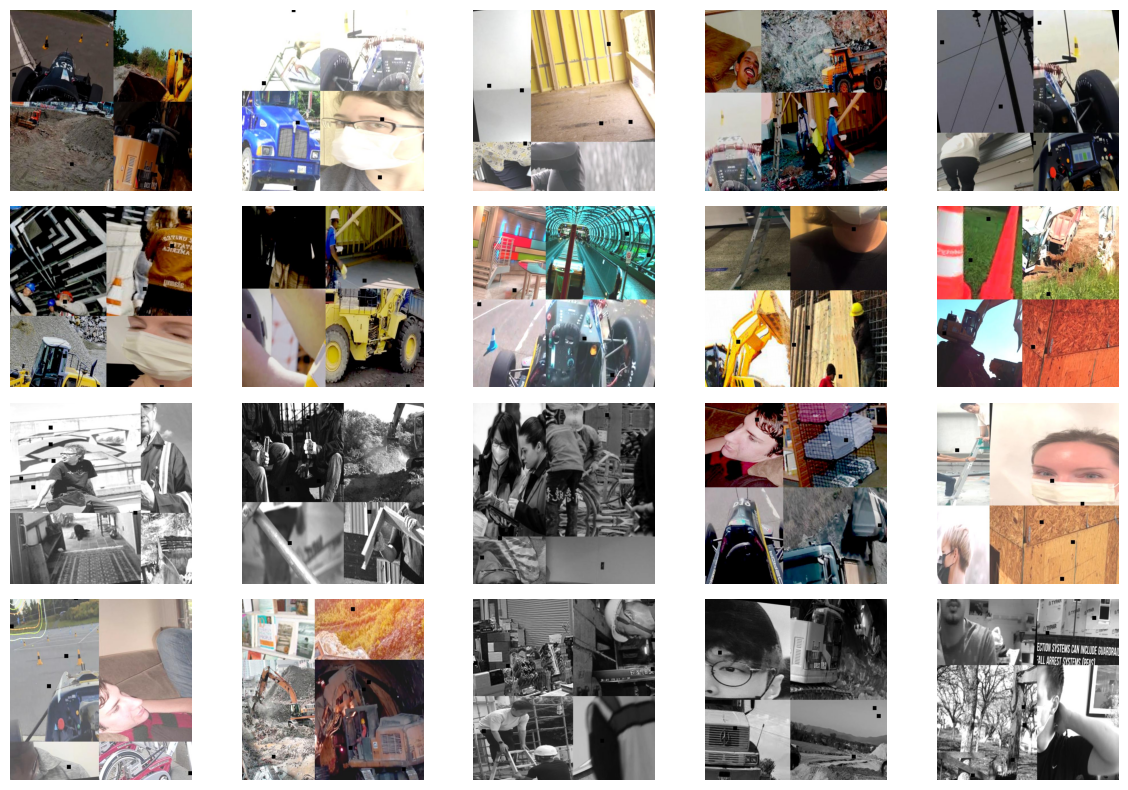

In [14]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [15]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)


    if img is None:
        raise ValueError("Could not read image file")

    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [16]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [17]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 507 ms, sys: 302 ms, total: 809 ms
Wall time: 40.2 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


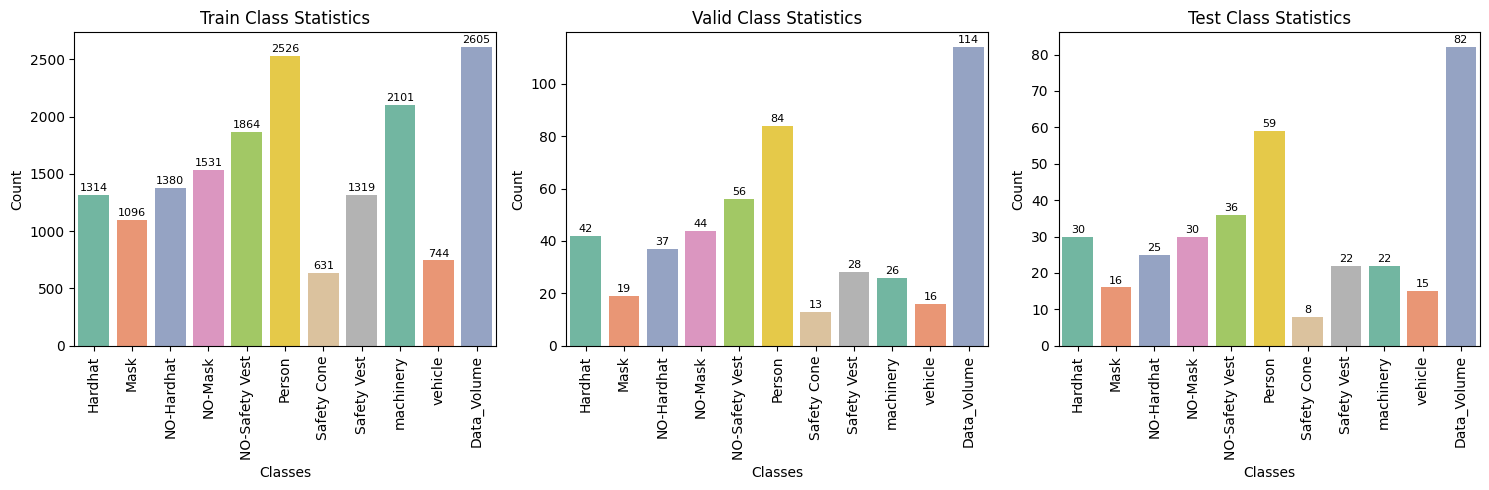

In [18]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [19]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 190 ms, sys: 101 ms, total: 291 ms
Wall time: 3.87 s


In [20]:
CFG.BASE_MODEL_WEIGHTS

'yolov8x.pt'

In [21]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [22]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = device, # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /content/drive/MyDrive/archive/css-data/train/images/-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.jpg: 640x640 3 persons, 97.5ms
Speed: 4.8ms preprocess, 97.5ms inference, 870.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



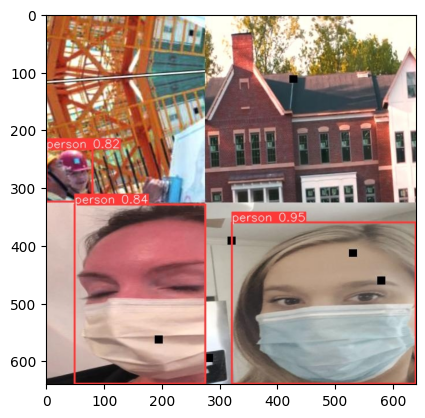

In [23]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/-1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.jpg')

In [24]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  50
Batch:  16


In [25]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [26]:

%%time

### train
model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    task='detect',
    imgsz=(img_properties['height'], img_properties['width']),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    weight_decay=CFG.WEIGHT_DECAY,
    dropout=CFG.DROPOUT,
    fraction=CFG.FRACTION,
    patience=CFG.PATIENCE,
    profile=CFG.PROFILE,
    label_smoothing=CFG.LABEL_SMOOTHING,
    name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed=CFG.SEED,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    device=0,  # Specify CPU as the device
    verbose=False,
)


Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=./data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 6.23M/6.23M [00:00<00:00, 95.1MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/drive/MyDrive/archive/css-data/train/labels.cache... 550 images, 1 backgrounds, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/archive/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/archive/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8x_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.5G      1.424      2.344      1.582        190        640: 100%|██████████| 35/35 [00:50<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

                   all        114        697      0.343      0.384      0.277      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      14.1G      1.365       1.82      1.524        156        640: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        114        697       0.21       0.32      0.164     0.0658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      14.1G       1.41      1.813      1.548         93        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        114        697      0.288      0.268      0.202      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      14.1G      1.381      1.771      1.555        134        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        114        697      0.347      0.279      0.227     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50        14G      1.352      1.738      1.539        106        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.13s/it]

                   all        114        697      0.464      0.342      0.318      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50        14G      1.334       1.68       1.53        100        640: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]

                   all        114        697      0.366      0.345      0.279       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      14.1G      1.321      1.624      1.483         83        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        114        697      0.451       0.35      0.322       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50        14G      1.259      1.516      1.472        136        640: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697        0.5      0.422      0.417      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      14.1G      1.265      1.474      1.465        148        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        114        697      0.489      0.437      0.372       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        14G      1.232      1.442       1.44        131        640: 100%|██████████| 35/35 [00:47<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        114        697      0.595      0.484      0.486      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        14G      1.238      1.426      1.432        155        640: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697      0.644      0.442      0.496      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      14.1G      1.173      1.366      1.421         99        640: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        114        697      0.638      0.449       0.46      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      14.1G      1.157      1.275      1.389        153        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        114        697      0.712       0.43      0.478      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      14.1G      1.165      1.271      1.378        178        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697      0.683        0.5      0.542       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        14G      1.123      1.217      1.354        143        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        114        697      0.678       0.51      0.531      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        14G      1.107      1.216      1.354        191        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.666      0.475      0.511      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        14G      1.102      1.172      1.347        110        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.673      0.523      0.553      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.1G        1.1      1.137      1.323        171        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        114        697      0.728      0.536      0.586       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50        14G       1.06      1.085      1.309        203        640: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        114        697      0.727      0.541      0.596      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        14G      1.041      1.043      1.293        188        640: 100%|██████████| 35/35 [00:48<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        114        697      0.699       0.55      0.583      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        14G      1.033      1.001      1.275        163        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        114        697      0.753       0.55      0.622      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      14.1G      1.045      1.054      1.303        146        640: 100%|██████████| 35/35 [00:47<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697       0.72      0.542      0.587      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        14G      1.017      1.003      1.279        100        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.761      0.557      0.609      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50        14G      0.979     0.9582      1.256        129        640: 100%|██████████| 35/35 [00:48<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        114        697      0.794      0.534       0.62      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50        14G     0.9684     0.9333      1.251        143        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.809      0.573      0.655      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        14G     0.9663     0.9004       1.23        211        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        114        697      0.767      0.607      0.649      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      14.1G      0.946     0.9181      1.231        158        640: 100%|██████████| 35/35 [00:47<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697      0.795      0.589      0.647      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      14.1G     0.9381      0.854      1.207        202        640: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

                   all        114        697      0.815      0.594      0.666      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        14G     0.9132     0.8375      1.201         90        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        114        697      0.821      0.613      0.677      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50        14G     0.8989     0.7995      1.194        188        640: 100%|██████████| 35/35 [00:48<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        114        697      0.749      0.551      0.608        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50        14G     0.8777     0.8079      1.179        110        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.788      0.596      0.647      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.8G     0.8616     0.7846      1.164         86        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        114        697       0.82      0.591      0.663      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      14.1G     0.8427      0.747      1.153        104        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.819      0.637      0.704      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      14.1G     0.8427     0.7387      1.158        132        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        114        697      0.835      0.633      0.708      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        14G     0.8299     0.7322      1.152        161        640: 100%|██████████| 35/35 [00:47<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        114        697      0.835      0.615      0.695      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      14.1G      0.801     0.7144      1.128        162        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.799      0.636       0.69      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        14G     0.7979     0.6967      1.132        149        640: 100%|██████████| 35/35 [00:48<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        114        697      0.829      0.634      0.695      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      14.1G     0.7841     0.6739      1.124        109        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.862      0.636      0.715      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      14.1G     0.7733     0.6561      1.108        208        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.838      0.624      0.691      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      14.1G     0.7543     0.6369       1.09         88        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.828      0.643      0.695      0.351


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50        14G     0.7784     0.6011      1.112         64        640: 100%|██████████| 35/35 [00:51<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        114        697      0.871      0.602      0.687      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50        14G     0.7627     0.5754      1.104         66        640: 100%|██████████| 35/35 [00:45<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.825      0.628      0.705      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        14G     0.7311     0.5336      1.074         88        640: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        114        697      0.867      0.623      0.712      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50        14G     0.7036     0.5212      1.068         96        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        114        697      0.879      0.625       0.71      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.9G     0.6852     0.5022      1.053         66        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.855      0.651       0.72       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50        14G     0.6757      0.479      1.044         95        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.864      0.643      0.717      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50        14G      0.663     0.4701      1.041        105        640: 100%|██████████| 35/35 [00:47<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.826      0.648      0.708      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50        14G     0.6383     0.4542      1.025         71        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        114        697      0.816      0.658      0.711      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50        14G     0.6243     0.4396      1.008         83        640: 100%|██████████| 35/35 [00:46<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        114        697      0.843      0.646      0.718      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50        14G     0.6281     0.4385      1.003         74        640: 100%|██████████| 35/35 [00:46<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        114        697       0.86      0.654      0.722      0.375



50 epochs completed in 0.852 hours.
Optimizer stripped from runs/detect/yolov8x_ppe_css_50_epochs/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt, 136.7MB

Validating runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


                   all        114        697      0.878      0.625       0.71      0.379
Speed: 0.5ms preprocess, 31.1ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/yolov8x_ppe_css_50_epochs
CPU times: user 33min 21s, sys: 8min 17s, total: 41min 39s
Wall time: 51min 53s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c484fc99570>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [27]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [28]:
model.export(
    format = 'openvino',
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.10 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs/detect/yolov8x_ppe_css_50_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (130.4 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 71.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 15.6s, saved as 'runs/detect/yolov8x_ppe_css_50_epochs/weights/best.onnx' (260.1 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 25.3 MB/s eta 0:00:00

'runs/detect/yolov8x_ppe_css_50_epochs/weights/best_openvino_model'

In [29]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/results.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/R_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/F1_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/P_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/PR_curve.png',
 './runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg',
 './runs/detect/yolov8x_ppe_css_50_epochs/labels_correlogram.jpg']

./runs/detect/yolov8x_ppe_css_50_epochs/F1_curve.png


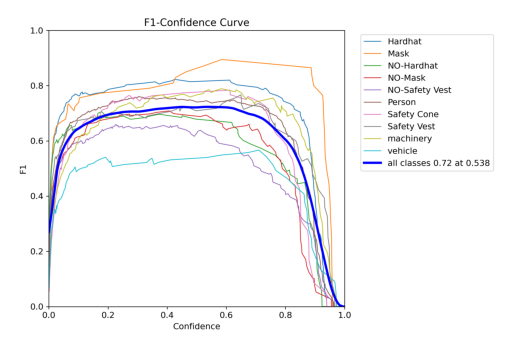



./runs/detect/yolov8x_ppe_css_50_epochs/PR_curve.png


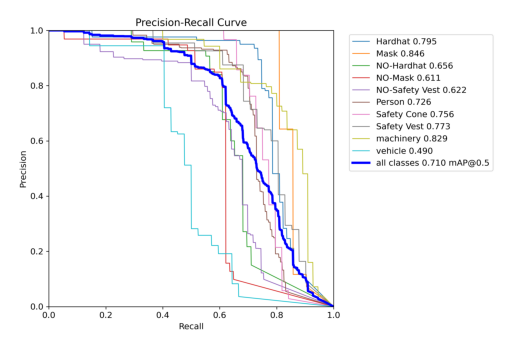



./runs/detect/yolov8x_ppe_css_50_epochs/P_curve.png


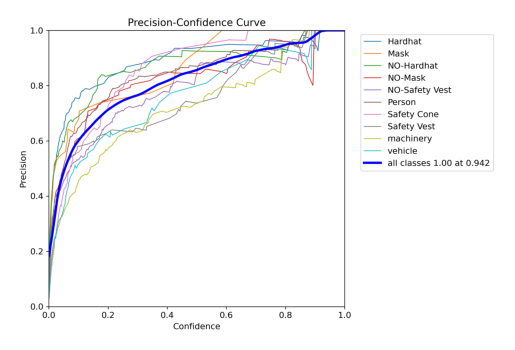



./runs/detect/yolov8x_ppe_css_50_epochs/R_curve.png


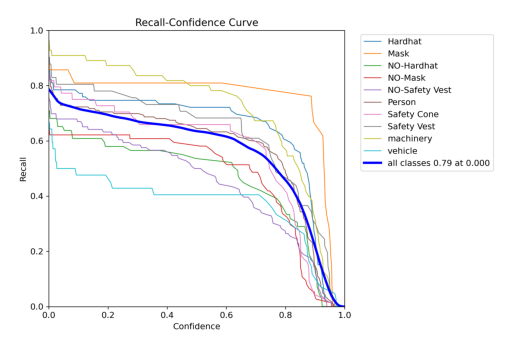



./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix.png


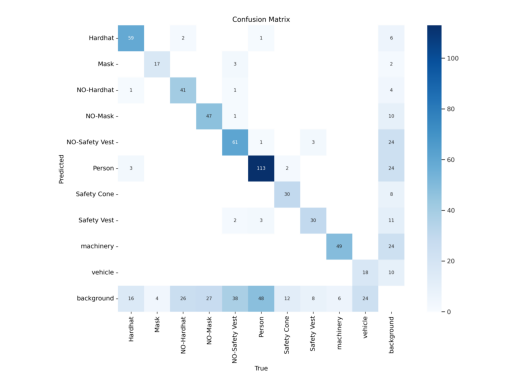



./runs/detect/yolov8x_ppe_css_50_epochs/confusion_matrix_normalized.png


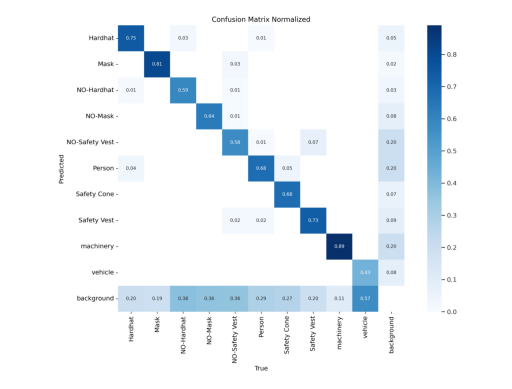



./runs/detect/yolov8x_ppe_css_50_epochs/labels.jpg


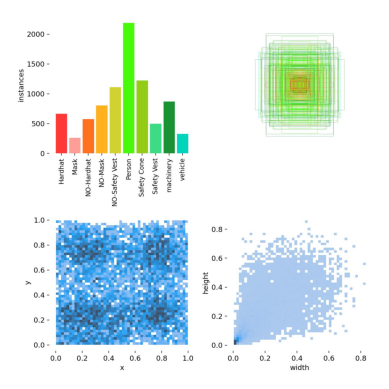



./runs/detect/yolov8x_ppe_css_50_epochs/labels_correlogram.jpg


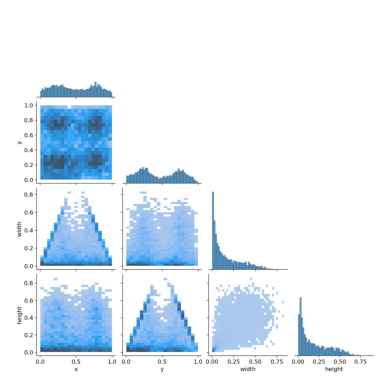



./runs/detect/yolov8x_ppe_css_50_epochs/results.png


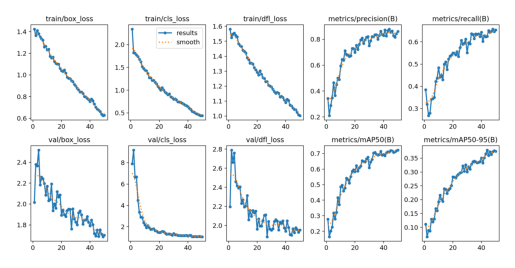

In [30]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [31]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.42400,2.34370,1.5817,0.34346,0.38447,0.27705,0.11102,2.0152,7.8957,2.1976,0.000231,0.000231,0.000231
1,2,1.36470,1.81960,1.5241,0.20989,0.31966,0.16448,0.06580,2.3786,9.1811,2.7896,0.000460,0.000460,0.000460
2,3,1.41020,1.81300,1.5476,0.28798,0.26784,0.20156,0.08897,2.3663,6.6512,2.6620,0.000679,0.000679,0.000679
3,4,1.38060,1.77140,1.5550,0.34736,0.27936,0.22656,0.08665,2.5165,6.6706,2.7594,0.000672,0.000672,0.000672
4,5,1.35160,1.73770,1.5392,0.46445,0.34183,0.31786,0.12914,2.1826,4.4810,2.4594,0.000672,0.000672,0.000672
5,6,1.33390,1.68040,1.5304,0.36602,0.34484,0.27855,0.11958,2.2584,3.3641,2.4151,0.000657,0.000657,0.000657
6,7,1.32120,1.62450,1.4833,0.45069,0.35016,0.32186,0.12982,2.2415,2.9022,2.3924,0.000643,0.000643,0.000643
7,8,1.25940,1.51610,1.4722,0.50019,0.42169,0.41671,0.16760,2.1972,2.8539,2.4043,0.000629,0.000629,0.000629
8,9,1.26460,1.47450,1.4647,0.48880,0.43661,0.37168,0.15997,2.0860,2.3836,2.2318,0.000615,0.000615,0.000615
9,10,1.23200,1.44220,1.4398,0.59518,0.48381,0.48595,0.19240,2.1700,2.1563,2.2686,0.000601,0.000601,0.000601


In [32]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.62432 , on epoch:  49 


Best Validation Box loss:  1.6865 , on epoch:  49 


Best Training Cls loss:  0.43851 , on epoch:  49 


Best Validation Cls loss:  1.0614 , on epoch:  49 


Best Training DFL loss:  1.0025 , on epoch:  49 


Best Validation DFL loss:  1.8822 , on epoch:  49 



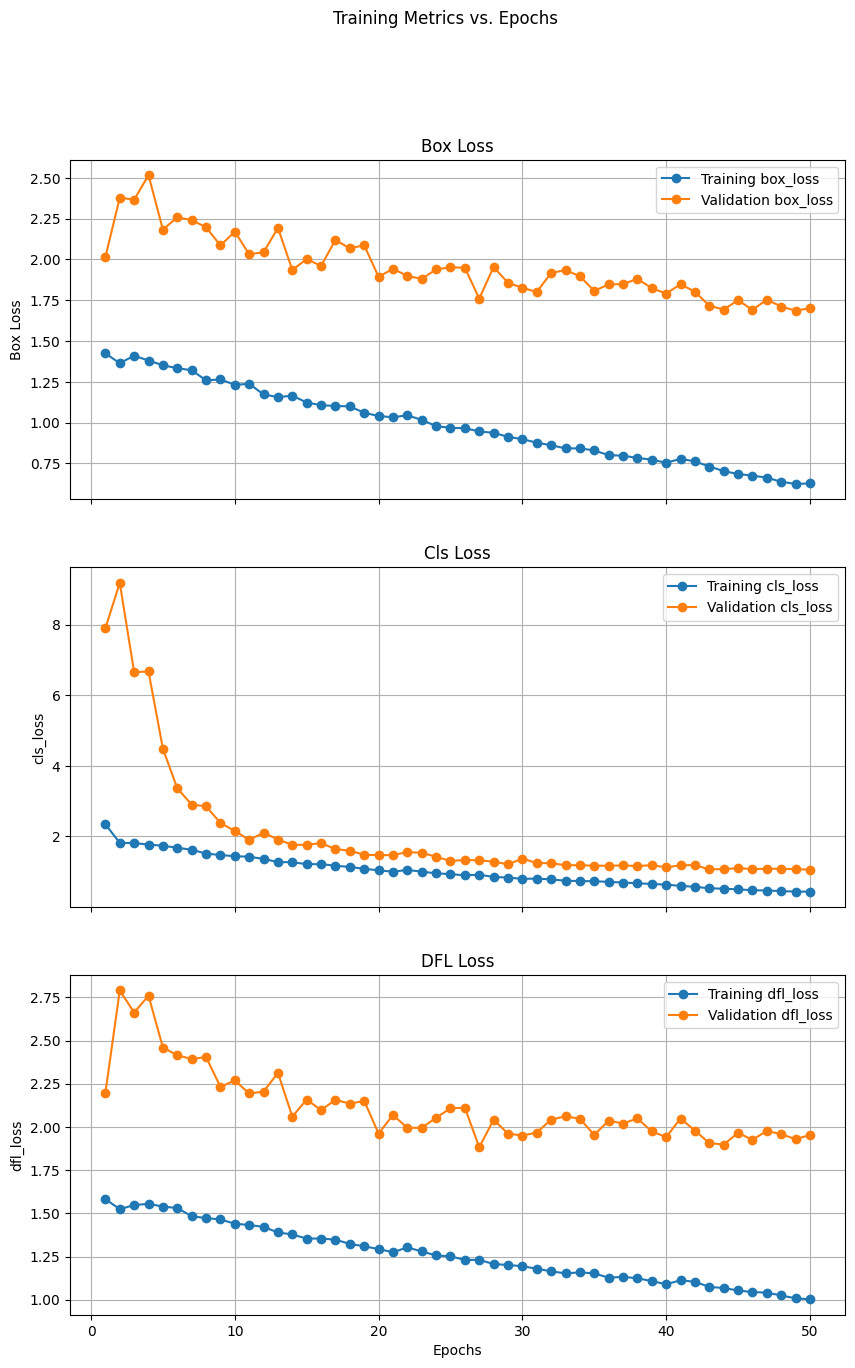

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [34]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [35]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8x_ppe_css_50_epochs/val_batch0_labels.jpg


./runs/detect/yolov8x_ppe_css_50_epochs/val_batch2_labels.jpg


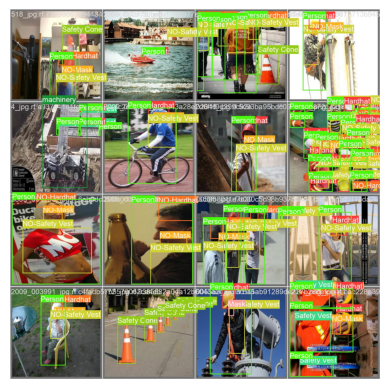

In [36]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)